To cluster students based on their patterns in studying

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# Data Loading and Merging
# ============================

# 1. Load your CSV files into DataFrames
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# Count how many unique assessments exist for each module + presentation
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# Compute average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()  # or .sum() if you prefer total score
    .reset_index()
    .rename(columns={"score": "score"})
)

df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# 3.1 Merge total_assessments (on code_module + code_presentation)
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how="left"
)

# 3.2 Merge attempted_assessments & average_score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how="left"
)

# 3.3 Merge total_vle_clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how="left"
)

# Replace NaN with 0 if needed
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"] = df_merged["total_assessments"].fillna(0)
df_merged["score"] = df_merged["score"].fillna(0)  # if missing, assume 0 or handle differently
df_merged["total_vle_clicks"] = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment_completion_ratio safely
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# Filter out withdrawn
df_merged = df_merged[
    (df_merged["final_result"] != "Withdrawn") 
].copy()

# Create binary target (Pass/Distinction=1, Fail=0)
df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# Rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# ---------------------------
# Final DataFrame including module
# ---------------------------
df_final = df_merged[
    [
        "id_student",
        "code_module",            # <-- include the module feature here
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))


    id_student code_module  score Gender                Region  \
0        11391         AAA   82.0      M   East Anglian Region   
1        28400         AAA   66.4      F              Scotland   
3        31604         AAA   76.0      F     South East Region   
4        32885         AAA   54.4      F  West Midlands Region   
5        38053         AAA   68.0      M                 Wales   
6        45462         AAA   68.0      M              Scotland   
7        45642         AAA   72.4      F  North Western Region   
8        52130         AAA   71.4      F   East Anglian Region   
9        53025         AAA   78.0      M          North Region   
10       57506         AAA   74.0      M          South Region   

                            HLE Age group  Credit Distribution  \
0              HE Qualification      55<=                  240   
1              HE Qualification     35-55                   60   
3         A Level or Equivalent     35-55                   60   
4        

  code_module  score Gender                Region                    HLE  \
0         AAA   82.0      M   East Anglian Region       HE Qualification   
1         AAA   66.4      F              Scotland       HE Qualification   
3         AAA   76.0      F     South East Region  A Level or Equivalent   
4         AAA   54.4      F  West Midlands Region     Lower Than A Level   
5         AAA   68.0      M                 Wales  A Level or Equivalent   

  Age group  Credit Distribution  assessment_completion_ratio  \
0      55<=                  240                     0.833333   
1     35-55                   60                     0.833333   
3     35-55                   60                     0.833333   
4      0-35                   60                     0.833333   
5     35-55                   60                     0.833333   

   total_vle_clicks  target  
0             934.0       1  
1            1435.0       1  
3            2158.0       1  
4            1034.0       1  
5 

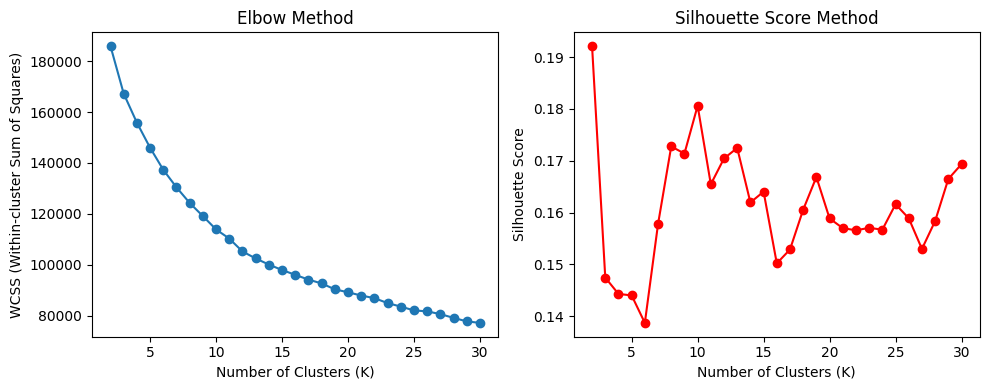

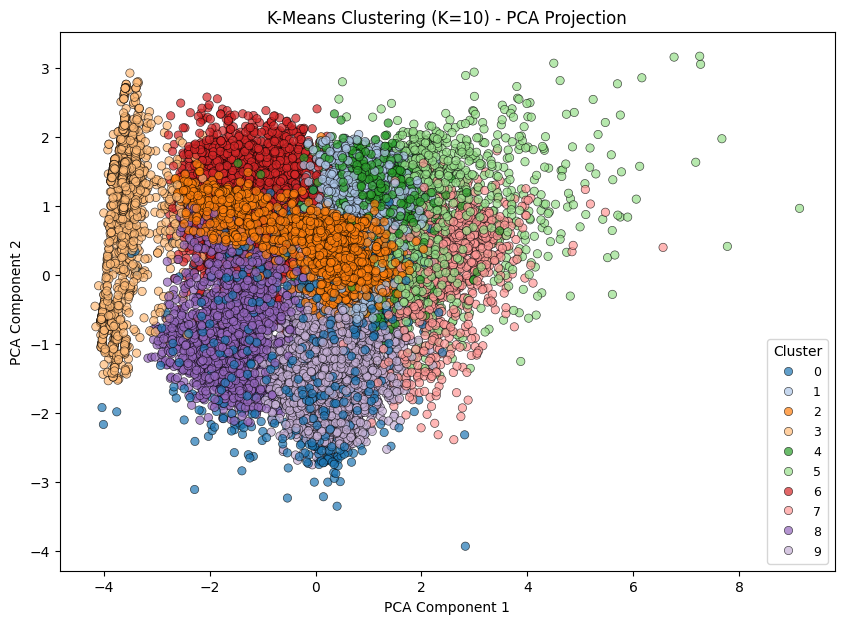

         code_module      score    Gender    Region       HLE  Age group  \
Cluster                                                                    
0           3.057387  71.611210  0.526252  5.987790  0.874237   0.219780   
1           3.822453  78.309177  0.984782  5.791134  0.821791   0.000000   
2           5.741124  78.377456  0.000493  5.714990  1.200197   0.361933   
3           3.399126   2.377624  0.539694  6.047342  1.307356   0.281136   
4           3.345903  79.234490  0.970670  5.683892  1.100093   1.060056   
5           3.965255  83.802928  0.651466  5.540717  1.119435   0.626493   
6           3.721091  65.384961  1.000000  6.012427  1.070418   0.228167   
7           3.146829  75.601520  0.821025  5.936577  0.779322   0.151173   
8           1.845550  66.180800  0.000000  5.887958  1.130890   0.246597   
9           1.436641  76.204110  0.008591  6.061211  0.826890   0.338488   

         Credit Distribution  assessment_completion_ratio  total_vle_clicks  \
Cluster 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ===========================
# Data Preprocessing
# ===========================

# Load your processed dataframe
df = df_final.copy()

# Drop student ID (not relevant for clustering)
df = df.drop(columns=['id_student'])

print(df.head())

# Encode categorical variables
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

# Standardize features for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# ===========================
# Finding Optimal K (Elbow & Silhouette Method)
# ===========================

wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K_range = range(2, 31)  # Trying K from 2 to 30
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(df_scaled, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-cluster Sum of Squares)")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")

plt.tight_layout()
plt.show()

# ===========================
# Applying K-Means with Optimal K
# ===========================

optimal_k = 10  # Change this based on elbow method & silhouette score analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# ===========================
# Visualizing Clusters using PCA (Better for 20 Clusters)
# ===========================

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(10, 7))

# Use a more distinct colormap
scatter = sns.scatterplot(
    x=df['PCA1'], y=df['PCA2'], hue=df['Cluster'], 
    palette="tab20", alpha=0.7, edgecolor="black"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (K={optimal_k}) - PCA Projection")

# Adjust legend for readability
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(9)  # Reduce font size for better visibility

plt.show()

# ===========================
# Display Cluster Statistics
# ===========================

print(df.groupby('Cluster').mean())  # Analyze the characteristics of each cluster


Calculate optimal eps

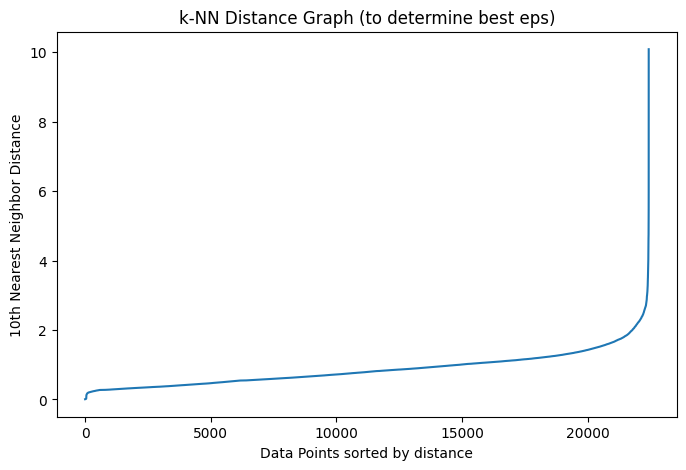

In [35]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Fit NearestNeighbors model
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# Sort and plot k-distance graph
distances = np.sort(distances[:, 9], axis=0)  # 10th neighbor distance
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel("Data Points sorted by distance")
plt.ylabel("10th Nearest Neighbor Distance")
plt.title("k-NN Distance Graph (to determine best eps)")
plt.show()


DBScan

      code_module     score    Gender    Region       HLE  Age group  \
PCA1     0.059342  0.406077  0.094246 -0.019253 -0.093801   0.077021   
PCA2     0.514711 -0.094822  0.440362 -0.075426  0.160259  -0.018251   

      Credit Distribution  assessment_completion_ratio  total_vle_clicks  \
PCA1             0.002711                     0.433189          0.372852   
PCA2            -0.163827                    -0.051841          0.170121   

        target          PCA1          PCA2  
PCA1  0.427849  5.457680e-01 -5.385886e-16  
PCA2 -0.138096  6.427187e-16  6.503222e-01  
Number of Clusters found by DBSCAN: 10


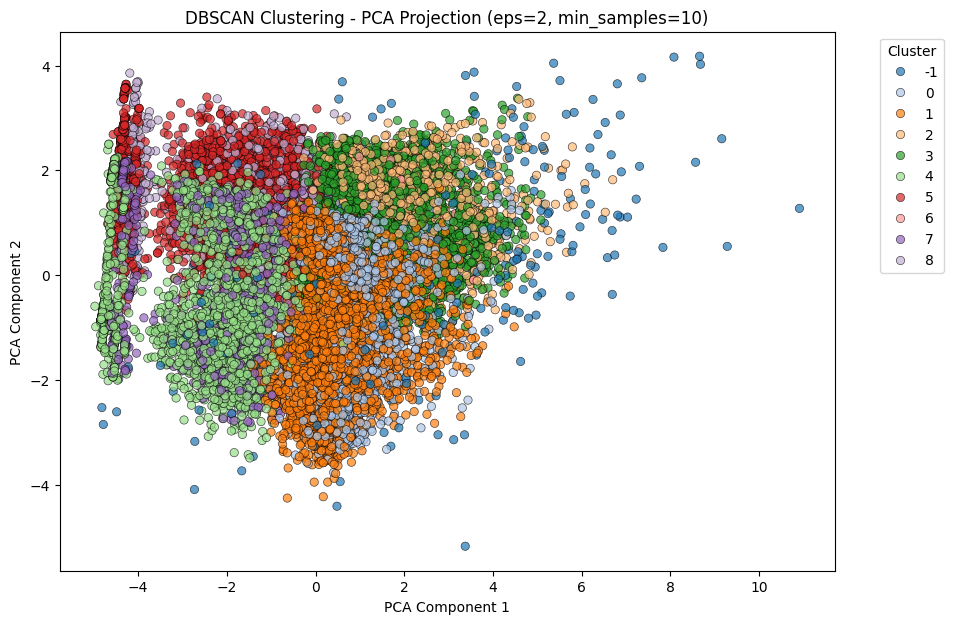

Number of noise points (outliers): 324


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ===========================
# Data Preprocessing
# ===========================

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['Cluster']))  # Exclude existing K-Means clusters


# Get the feature names from the original DataFrame (excluding 'Cluster')
feature_names = df.drop(columns=['Cluster']).columns

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=feature_names)

# Now perform PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

# Create a DataFrame for the component loadings
loadings = pd.DataFrame(pca.components_, columns=df_scaled.columns, index=['PCA1', 'PCA2'])
print(loadings)

# ===========================
# Apply DBSCAN
# ===========================

# Tune parameters: eps (radius), min_samples (min points per cluster)
dbscan = DBSCAN(eps=2, min_samples=10)  # Adjust these values if needed
df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

# Count the number of unique clusters (DBSCAN assigns -1 to noise points)
num_clusters = len(set(df['DBSCAN_Cluster'])) - (1 if -1 in df['DBSCAN_Cluster'] else 0)
print(f"Number of Clusters found by DBSCAN: {num_clusters}")

# ===========================
# Visualizing DBSCAN Clusters using PCA
# ===========================

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]


plt.figure(figsize=(10, 7))

# Plot DBSCAN clusters
sns.scatterplot(
    x=df['PCA1'], y=df['PCA2'], hue=df['DBSCAN_Cluster'], 
    palette="tab20", alpha=0.7, edgecolor="black"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"DBSCAN Clustering - PCA Projection (eps={dbscan.eps}, min_samples={dbscan.min_samples})")

# Adjust legend for readability
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# ===========================
# Check How Many Points Were Classified as Noise (-1)
# ===========================

num_noise = sum(df['DBSCAN_Cluster'] == -1)
print(f"Number of noise points (outliers): {num_noise}")


In [37]:
# ----- Cluster Profiling for Numeric Features -----
# Define the numeric columns you want to summarize.
numeric_cols = ['score', 'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks']

# Compute the mean and median for each numeric feature per cluster.
cluster_numeric_profiles = df.groupby('Cluster')[numeric_cols].agg(['mean', 'median'])
print("Numeric Cluster Profiles:")
print(cluster_numeric_profiles)

# ----- Cluster Profiling for Categorical Features -----
# Define the categorical columns (these are still in their original or label-encoded form).
categorical_cols = ['code_module', 'Gender', 'Region', 'HLE', 'Age group']

# For categorical features, we can use the mode (most common value) to summarize each cluster.
def mode_func(series):
    return series.mode().iloc[0]

cluster_categorical_profiles = df.groupby('Cluster')[categorical_cols].agg(mode_func)
print("\nCategorical Cluster Profiles:")
print(cluster_categorical_profiles)

# ----- Alternative: Detailed Summary for Each Cluster -----
# This loop prints a full descriptive summary for each cluster, including counts and other stats.
for cluster, group in df.groupby('Cluster'):
    print(f"\nCluster {cluster} Detailed Summary:")
    print(group.describe(include='all'))


Numeric Cluster Profiles:
             score            Credit Distribution         \
              mean     median                mean median   
Cluster                                                    
0        71.611210  73.000000          185.152625  180.0   
1        78.309177  79.500000           72.386414   60.0   
2        78.377456  80.250000           39.297337   30.0   
3         2.377624   0.000000           69.639476   60.0   
4        79.234490  80.500000           67.604749   60.0   
5        83.802928  85.857143           77.079262   60.0   
6        65.384961  66.000000           73.436313   60.0   
7        75.601520  77.090909           75.664639   60.0   
8        66.180800  67.666667           77.910995   60.0   
9        76.204110  78.222222           75.388746   60.0   

        assessment_completion_ratio           total_vle_clicks          
                               mean    median             mean  median  
Cluster                                        

Now we add the profile/cluster as a new feature to re run our algos

In [38]:
# Add the DBSCAN cluster labels to the dataset
df_final['DBSCAN_Cluster'] = df['DBSCAN_Cluster']

# Convert cluster labels to categorical type (important for tree-based models)
df_final['DBSCAN_Cluster'] = df_final['DBSCAN_Cluster'].astype('category')

# Check new dataset with clusters
print(df_final.head())


   id_student code_module  score Gender                Region  \
0       11391         AAA   82.0      M   East Anglian Region   
1       28400         AAA   66.4      F              Scotland   
3       31604         AAA   76.0      F     South East Region   
4       32885         AAA   54.4      F  West Midlands Region   
5       38053         AAA   68.0      M                 Wales   

                     HLE Age group  Credit Distribution  \
0       HE Qualification      55<=                  240   
1       HE Qualification     35-55                   60   
3  A Level or Equivalent     35-55                   60   
4     Lower Than A Level      0-35                   60   
5  A Level or Equivalent     35-55                   60   

   assessment_completion_ratio  total_vle_clicks  target DBSCAN_Cluster  
0                     0.833333             934.0       1             -1  
1                     0.833333            1435.0       1              0  
3                     0.833333  

# Final Results


## Preprocessing


In [39]:
import numpy as np
import pandas as pd

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import clone

# ===========================
# 1) Preprocessing
# ===========================

# Example: Add DBSCAN Cluster Labels to Features
df_final['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].astype('category')  # Ensure categorical type

# Define features including DBSCAN cluster and module
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module', 'DBSCAN_Cluster'  # <-- Added DBSCAN cluster
]

X = df_final[features]
y = df_final['target']

# One-Hot Encode Categorical Features
X_encoded = pd.get_dummies(
    X, 
    columns=['Gender', 'Region', 'HLE', 'Age group', 'code_module', 'DBSCAN_Cluster'], 
    drop_first=True
)

# Create Sample Weights by Module
module_counts = df_final['code_module'].value_counts()
df_final['module_weight'] = df_final['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = df_final['module_weight']

# Define Models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=3, bootstrap=True, 
                                            oob_score=True, class_weight='balanced', random_state=42),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42),
        n_estimators=100, random_state=42
    )
}

print("Preprocessing complete. Features and models are defined.")


Preprocessing complete. Features and models are defined.


## Train/Holdout Splitting

In [40]:
# 2) A: Single Train/Holdout Split

X_train_all, X_holdout, y_train_all, y_holdout, w_train_all, w_holdout = train_test_split(
    X_encoded, y, sample_weights, test_size=0.25, random_state=42, stratify=y
)

print("Train/Holdout split completed.")
print("Training set size:", X_train_all.shape[0])
print("Holdout set size:", X_holdout.shape[0])


Train/Holdout split completed.
Training set size: 16827
Holdout set size: 5610


## K-Fold Cross-Validation on training subset

In [41]:
# 3) B: Perform K-Fold Cross-Validation on the training subset
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_results = {model_name: {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'auc': []}
              for model_name in models.keys()}

for fold, (train_index, val_index) in enumerate(skf.split(X_train_all, y_train_all), start=1):
    X_cv_train = X_train_all.iloc[train_index]
    X_cv_val   = X_train_all.iloc[val_index]
    y_cv_train = y_train_all.iloc[train_index]
    y_cv_val   = y_train_all.iloc[val_index]
    w_cv_train = w_train_all.iloc[train_index]
    w_cv_val   = w_train_all.iloc[val_index]
    
    print(f"\n===== Cross-Validation Fold {fold} =====")
    
    for model_name, model in models.items():
        # Clone the model so each fold starts fresh
        clf = clone(model)
        clf.fit(X_cv_train, y_cv_train, sample_weight=w_cv_train)
        
        y_cv_pred = clf.predict(X_cv_val)
        y_cv_proba = clf.predict_proba(X_cv_val)[:, 1]  # for AUC
        
        # Compute metrics
        acc  = accuracy_score(y_cv_val, y_cv_pred)
        bal_acc = balanced_accuracy_score(y_cv_val, y_cv_pred)
        f1   = f1_score(y_cv_val, y_cv_pred)
        auc  = roc_auc_score(y_cv_val, y_cv_proba, sample_weight=w_cv_val)
        
        cv_results[model_name]['accuracy'].append(acc)
        cv_results[model_name]['balanced_accuracy'].append(bal_acc)
        cv_results[model_name]['f1'].append(f1)
        cv_results[model_name]['auc'].append(auc)
        
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        
print("\n===== Cross-Validation Summary =====")
for model_name in models.keys():
    avg_acc = np.mean(cv_results[model_name]['accuracy'])
    avg_bal_acc = np.mean(cv_results[model_name]['balanced_accuracy'])
    avg_f1 = np.mean(cv_results[model_name]['f1'])
    avg_auc = np.mean(cv_results[model_name]['auc'])
    
    print(f"\n{model_name} Averages (k={k} folds):")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Balanced Accuracy: {avg_bal_acc:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    print(f"AUC: {avg_auc:.4f}")



===== Cross-Validation Fold 1 =====

Model: Decision Tree
Accuracy: 0.9590
Balanced Accuracy: 0.9404
F1 Score: 0.9707
AUC: 0.9304

Model: Random Forest
Accuracy: 0.9673
Balanced Accuracy: 0.9536
F1 Score: 0.9765
AUC: 0.9971

Model: AdaBoost
Accuracy: 0.9970
Balanced Accuracy: 0.9953
F1 Score: 0.9978
AUC: 0.9997

===== Cross-Validation Fold 2 =====

Model: Decision Tree
Accuracy: 0.9638
Balanced Accuracy: 0.9510
F1 Score: 0.9739
AUC: 0.9532

Model: Random Forest
Accuracy: 0.9739
Balanced Accuracy: 0.9640
F1 Score: 0.9811
AUC: 0.9976

Model: AdaBoost
Accuracy: 0.9964
Balanced Accuracy: 0.9964
F1 Score: 0.9974
AUC: 0.9996

===== Cross-Validation Fold 3 =====

Model: Decision Tree
Accuracy: 0.9643
Balanced Accuracy: 0.9515
F1 Score: 0.9743
AUC: 0.9458

Model: Random Forest
Accuracy: 0.9750
Balanced Accuracy: 0.9644
F1 Score: 0.9820
AUC: 0.9977

Model: AdaBoost
Accuracy: 0.9964
Balanced Accuracy: 0.9943
F1 Score: 0.9974
AUC: 0.9996

===== Cross-Validation Fold 4 =====

Model: Decision Tree

## Perf on entire training dataset

In [42]:
# 4) C: Training performance on the entire training subset
training_scores = {}

for model_name, model in models.items():
    # Fit on all training data
    clf = clone(model)
    clf.fit(X_train_all, y_train_all, sample_weight=w_train_all)
    
    y_train_pred = clf.predict(X_train_all)
    y_train_proba = clf.predict_proba(X_train_all)[:, 1]
    
    acc_train = accuracy_score(y_train_all, y_train_pred)
    bal_acc_train = balanced_accuracy_score(y_train_all, y_train_pred)
    f1_train = f1_score(y_train_all, y_train_pred)
    auc_train = roc_auc_score(y_train_all, y_train_proba, sample_weight=w_train_all)
    
    training_scores[model_name] = {
        'accuracy': acc_train,
        'balanced_accuracy': bal_acc_train,
        'f1': f1_train,
        'auc': auc_train
    }

print("\n===== Training Performance on Entire Training Subset =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {training_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {training_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {training_scores[model_name]['f1']:.4f}")
    print(f"AUC: {training_scores[model_name]['auc']:.4f}")



===== Training Performance on Entire Training Subset =====

Decision Tree:
Accuracy: 0.9627
Balanced Accuracy: 0.9485
F1 Score: 0.9732
AUC: 0.9457

Random Forest:
Accuracy: 0.9715
Balanced Accuracy: 0.9599
F1 Score: 0.9794
AUC: 0.9970

AdaBoost:
Accuracy: 0.9958
Balanced Accuracy: 0.9939
F1 Score: 0.9969
AUC: 0.9995


## Perf on holdout

In [43]:
# 5) D: Validation (Holdout) Performance
validation_scores = {}

for model_name, model in models.items():
    # Refit each model on the entire training set
    clf = clone(model)
    clf.fit(X_train_all, y_train_all, sample_weight=w_train_all)
    
    y_val_pred = clf.predict(X_holdout)
    y_val_proba = clf.predict_proba(X_holdout)[:, 1]
    
    acc_val = accuracy_score(y_holdout, y_val_pred)
    bal_acc_val = balanced_accuracy_score(y_holdout, y_val_pred)
    f1_val = f1_score(y_holdout, y_val_pred)
    auc_val = roc_auc_score(y_holdout, y_val_proba)
    
    validation_scores[model_name] = {
        'accuracy': acc_val,
        'balanced_accuracy': bal_acc_val,
        'f1': f1_val,
        'auc': auc_val
    }

print("\n===== Final Holdout (Validation) Performance =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {validation_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {validation_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {validation_scores[model_name]['f1']:.4f}")
    print(f"AUC: {validation_scores[model_name]['auc']:.4f}")
    
    # If you want, you can also see confusion matrix on the holdout
    clf = clone(models[model_name])
    clf.fit(X_train_all, y_train_all, sample_weight=w_train_all)
    y_val_pred2 = clf.predict(X_holdout)
    print("Confusion Matrix:")
    print(confusion_matrix(y_holdout, y_val_pred2))



===== Final Holdout (Validation) Performance =====

Decision Tree:
Accuracy: 0.9654
Balanced Accuracy: 0.9519
F1 Score: 0.9751
AUC: 0.9542
Confusion Matrix:
[[1614  149]
 [  45 3802]]

Random Forest:
Accuracy: 0.9742
Balanced Accuracy: 0.9641
F1 Score: 0.9813
AUC: 0.9976
Confusion Matrix:
[[1652  111]
 [  34 3813]]

AdaBoost:
Accuracy: 0.9973
Balanced Accuracy: 0.9959
F1 Score: 0.9981
AUC: 0.9998
Confusion Matrix:
[[1749   14]
 [   1 3846]]


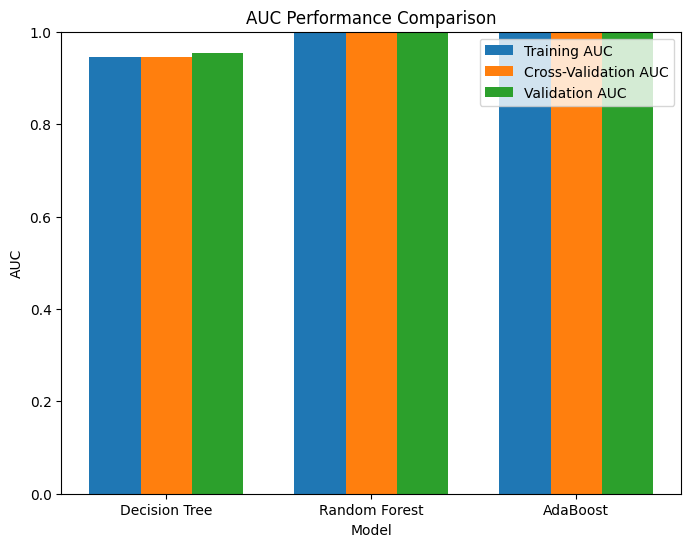

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# List of model names (keys from the dictionaries)
models_list = list(training_scores.keys())

# Extract the AUC values from each dictionary
train_auc = [training_scores[m]['auc'] for m in models_list]
cv_auc = [np.mean(cv_results[m]['auc']) for m in models_list]
val_auc = [validation_scores[m]['auc'] for m in models_list]

# X-axis positions for each model
x = np.arange(len(models_list))
width = 0.25  # width of each bar

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(x - width, train_auc, width, label='Training AUC')
plt.bar(x, cv_auc, width, label='Cross-Validation AUC')
plt.bar(x + width, val_auc, width, label='Validation AUC')

plt.xlabel("Model")
plt.ylabel("AUC")
plt.title("AUC Performance Comparison")
plt.xticks(x, models_list)
plt.ylim(0, 1)
plt.legend()
plt.show()


# XAI Stuff


Feature Importance (Global)

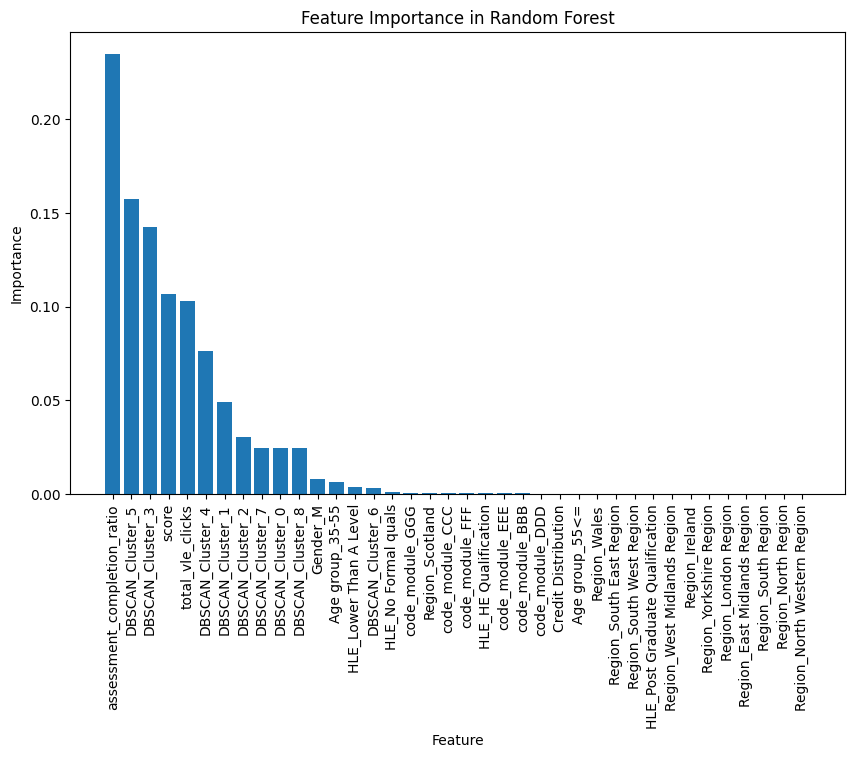

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the Random Forest model
rf_model = models["Random Forest"]  # Get the trained RF model

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_encoded.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


## SHAP for Global & Local Explainability (XAI)

In [46]:
import shap

# Initialize SHAP explainer for Random Forest
rf_model = models["Random Forest"]  # Get the trained RF model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values[:, :, 0], X_test, feature_names=X_encoded.columns)



ModuleNotFoundError: No module named 'shap'

In [ ]:
# Print the shape of the test data
print("X_test shape:", X_test.shape)

# Print the columns of the encoded features
print("Columns in X_encoded:", list(X_encoded.columns))

# Check the shape of the shap_values
if isinstance(shap_values, list):
    # If it's a list (likely one array per class), print shape for each
    for i, arr in enumerate(shap_values):
        print(f"Shape of shap_values[{i}]:", arr.shape)
else:
    print("Shape of shap_values:", shap_values.shape)
